In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_2019 = 'data/2019.csv'

election_2019 = pd.read_csv(DATA_2019, encoding='utf-8', 
                            names=['community', 'province', 'election_year', 
                                   'party', 'votes', 'percent', 'seats', 'iteration'])

In [3]:
election_2019.head(10)

,community,province,election_year,party,votes,percent,seats,iteration
0,NaN,NaN,2019,Censo,36898883,NaN,NaN,NaN
1,NaN,NaN,2019,Votantes,26478140,71.8,NaN,NaN
2,NaN,NaN,2019,Nulos,276769,NaN,NaN,NaN
3,NaN,NaN,2019,V&aacute;lidos,26201371,NaN,NaN,NaN
4,NaN,NaN,2019,Blancos,199836,NaN,NaN,NaN
5,NaN,NaN,2019,Partido Socialista Obrero Espa&ntilde;ol (PSOE),7513142,28.7,123.0,NaN
6,NaN,NaN,2019,Partido Popular (PP),4373653,16.7,66.0,NaN
7,NaN,NaN,2019,Ciudadanos-Partido de la Ciudadan&iacute;a (C's),4155665,15.9,57.0,NaN
8,NaN,NaN,2019,Unidas Podemos (PODEMOS-IU-EQUO),3751145,14.3,42.0,NaN
9,NaN,NaN,2019,Vox (VOX),2688092,10.3,24.0,NaN


In [4]:
election_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   community      1712 non-null   float64
 1   province       1426 non-null   float64
 2   election_year  1760 non-null   int64  
 3   party          1760 non-null   object 
 4   votes          1760 non-null   int64  
 5   percent        1256 non-null   float64
 6   seats          1130 non-null   float64
 7   iteration      890 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 110.1+ KB


In [5]:
# reformatting spanish chars
accent_map = {'&aacute;': 'á', '&ntilde;': 'ñ', '&iacute;': 'í',
              '&oacute;': 'ó', '&Iacute;': 'Í', '&agrave;': 'à',
              '&Agrave;': 'À', '&Aacute;': 'Á', '&iexcl;': '¡',
              '&uacute;': 'ú', '&Uacute;': 'Ú', '&eacute;': 'é',
              '&Eacute;': 'É'}

party_names_cleaned = list(election_2019.party)
for k in accent_map:
    party_names_cleaned = [re.sub(k, accent_map[k], i) for i in party_names_cleaned]

election_2019['party'] = party_names_cleaned

In [6]:
# Nan values in 'community' col represent totals for entire country - we'll code Spain totals as 0
election_2019['community'] = election_2019.community.fillna(0.0)
election_2019['province'] = election_2019.province.fillna(0.0)

# mapping community codes to community names
comm_dict = {0: 'Spain', 1: 'Andalucía', 2: 'Aragón', 3: 'Asturias',
            4: 'Illes Balears', 5: 'Canarias', 6: 'Cantabria', 7:'Castilla-La Mancha',
            8: 'Castilla y León', 9: 'Cataluña', 10: 'Extremadura', 11: 'Galicia',
            12: 'Madrid', 13: 'Navarra', 14: 'País Vasco', 15: 'Región de Murcia',
            16: 'La Rioja', 17: 'Comunidad Valenciana', 18: 'Ceuta', 19: 'Melilla'}


election_2019['community_name'] = election_2019['community'].map(comm_dict)

In [7]:
# filling in election month info - two elections were held in 2019 (April and November)
election_2019['iteration'] = election_2019.iteration.fillna('A')

april_index = election_2019[election_2019['iteration']=='A'].index
nov_index = election_2019[election_2019['iteration']=='B'].index

election_2019.loc[april_index, 'election_year'] = 'april-2019'
election_2019.loc[nov_index, 'election_year'] = 'november-2019'

# drop 'iteration' column
election_2019.drop('iteration', axis=1, inplace=True)

# split the two datasets by election

april_2019 = election_2019[election_2019['election_year']=='april-2019'].reset_index(drop=True)
nov_2019 = election_2019[election_2019['election_year']=='november-2019'].reset_index(drop=True)

In [8]:
# for an inputted dataframe, 
#separate the data relating to community-wide totals 
#from the data about specific political parties

def get_parties_data(df):
    
    election_totals = df[df['party'].isin(['Censo', 'Votantes', 'Nulos', 'Blancos', 'Válidos'])].reset_index(drop=True)
    party_totals = df[df['party'].isin(['Censo', 'Votantes', 'Nulos', 'Blancos', 'Válidos'])==False].reset_index(drop=True)
    
    return election_totals, party_totals

april_2019_totals, april_2019_parties = get_parties_data(april_2019)
nov_2019_totals, nov_2019_parties = get_parties_data(nov_2019)


# group by number of votes receievd by each party in each community
apr_parties_counts_2019 = april_2019_parties.groupby('party')['votes'].sum().sort_values(ascending=False)
nov_parties_counts_2019 = nov_2019_parties.groupby('party')['votes'].sum().sort_values(ascending=False)

In [14]:
#andalucia = april_2019_parties[april_2019_parties.community_name=='Andalucia']
#test = andalucia.groupby('party')['votes'].sum().sort_values(ascending=False).head(3)

In [38]:
def get_regional_winners(df):
    
    comm_names = list(df.community_name.unique())
    regional_winners = []
    
    for c in comm_names:
        comm_data = df[df.community_name==c]
        party_totals = pd.DataFrame(comm_data.groupby('party')['votes'].sum().sort_values(ascending=False).head(3)).reset_index()
        party_totals['community_name'] = c
        regional_winners.append(party_totals)
        
        #winning_party_name = party_totals.idxmax()
        #winning_party_votes = party_totals.max()
        #regional_winners.append((c, winning_party_name, winning_party_votes))
        
    regional_winners = pd.concat(regional_winners)
    regional_winners.set_index('community_name', drop=True, inplace=True)
    
    return regional_winners
    

In [41]:
april_regional_winners = get_regional_winners(april_2019_parties)

In [42]:
nov_regional_winners = get_regional_winners(nov_2019_parties)

In [43]:
import seaborn as sns
import geopandas as gpd

sns.set_style('white')
sns.set(fon_scale=1.5)

In [70]:
ccaa_shpfile = gpd.read_file('data/shapefiles_ccaa_espana.geojson')
#base_map = base_map

In [78]:
mainland = ccaa_shpfile[ccaa_shpfile['name_1'].isin(['Islas Baleares', 'Islas Canarias', 'Ceuta y Melilla'])==False]
mainland = mainland.to_crs({'init':'epsg:2062'})

islas_canarias = ccaa_shpfile[ccaa_shpfile.name_1=='Islas Canarias']
islas_canarias = islas_canarias.to_crs({'init':'epsg:2062'})

islas_baleares = ccaa_shpfile[ccaa_shpfile.name_1=='Islas Baleares']
islas_baleares = islas_baleares.to_crs({'init':'epsg:2062'})

ceuta_melilla = ccaa_shpfile[ccaa_shpfile.name_1=='Ceuta y Melilla']
ceuta_melilla = ceuta_melilla.to_crs({'init':'epsg:2062'})

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

mainland.plot(ax=ax, facecolor='lightgray', edgecolor='gray')

ax.axis('equal')
ax.set_axis_off()

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


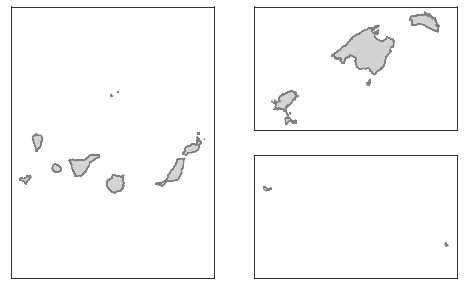

In [83]:
from matplotlib.gridspec import GridSpec

fig=plt.figure(figsize=(8,5))

gs = GridSpec(2,2)

ax1=fig.add_subplot(gs[:,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[1,1])


islas_canarias.plot(ax=ax1, facecolor='lightgray', edgecolor='gray')
islas_baleares.plot(ax=ax2, facecolor='lightgray', edgecolor='gray')
ceuta_melilla.plot(ax=ax3, facecolor='lightgray', edgecolor='gray')

ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)


fig.show();